<a href="https://colab.research.google.com/github/Abhishek500/ERA/blob/main/S8/ERA_S8_GN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/ERA V1')
from model import *

Mounted at /content/drive


In [2]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822 ,0.4465), (0.2470, 0.2435, 0.2616))])
test_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822 ,0.4465), (0.2470, 0.2435, 0.2616))])



In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:

train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

# Load the CIFAR-10 test dataset
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)


100%|██████████| 170498071/170498071 [00:01<00:00, 103660232.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=3, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = S8_Model_GN().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
         GroupNorm-2           [-1, 32, 32, 32]              64
         Dropout2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
         GroupNorm-5           [-1, 64, 32, 32]             128
         Dropout2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 10, 32, 32]             640
         GroupNorm-8           [-1, 10, 32, 32]              20
         Dropout2d-9           [-1, 10, 32, 32]               0
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 16, 14, 14]           1,440
        GroupNorm-12           [-1, 16, 14, 14]              32

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    #return test_loss

In [8]:
model =  S8_Model_GN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.9933613538742065 Batch_id=1562 Accuracy=37.67: 100%|██████████| 1563/1563 [00:44<00:00, 35.23it/s]



Test set: Average loss: 1.4684, Accuracy: 4578/10000 (45.78%)

EPOCH: 1


Loss=1.216373324394226 Batch_id=1562 Accuracy=49.93: 100%|██████████| 1563/1563 [00:33<00:00, 46.58it/s]



Test set: Average loss: 1.3008, Accuracy: 5382/10000 (53.82%)

EPOCH: 2


Loss=0.8806873559951782 Batch_id=1562 Accuracy=56.54: 100%|██████████| 1563/1563 [00:33<00:00, 46.33it/s]



Test set: Average loss: 1.1110, Accuracy: 6024/10000 (60.24%)

EPOCH: 3


Loss=1.178853988647461 Batch_id=1562 Accuracy=60.78: 100%|██████████| 1563/1563 [00:35<00:00, 43.67it/s]



Test set: Average loss: 1.0273, Accuracy: 6398/10000 (63.98%)

EPOCH: 4


Loss=0.956967294216156 Batch_id=1562 Accuracy=63.97: 100%|██████████| 1563/1563 [00:35<00:00, 44.09it/s]



Test set: Average loss: 0.9470, Accuracy: 6652/10000 (66.52%)

EPOCH: 5


Loss=0.8504221439361572 Batch_id=1562 Accuracy=66.17: 100%|██████████| 1563/1563 [00:33<00:00, 46.82it/s]



Test set: Average loss: 0.8982, Accuracy: 6838/10000 (68.38%)

EPOCH: 6


Loss=0.7673883438110352 Batch_id=1562 Accuracy=67.71: 100%|██████████| 1563/1563 [00:34<00:00, 45.72it/s]



Test set: Average loss: 0.8802, Accuracy: 6939/10000 (69.39%)

EPOCH: 7


Loss=0.6253960728645325 Batch_id=1562 Accuracy=69.34: 100%|██████████| 1563/1563 [00:33<00:00, 47.27it/s]



Test set: Average loss: 0.8398, Accuracy: 7074/10000 (70.74%)

EPOCH: 8


Loss=0.8377191424369812 Batch_id=1562 Accuracy=70.48: 100%|██████████| 1563/1563 [00:35<00:00, 44.20it/s]



Test set: Average loss: 0.8586, Accuracy: 7026/10000 (70.26%)

EPOCH: 9


Loss=0.9451901912689209 Batch_id=1562 Accuracy=71.37: 100%|██████████| 1563/1563 [00:33<00:00, 46.84it/s]



Test set: Average loss: 0.8253, Accuracy: 7085/10000 (70.85%)

EPOCH: 10


Loss=1.0367062091827393 Batch_id=1562 Accuracy=72.07: 100%|██████████| 1563/1563 [00:33<00:00, 46.28it/s]



Test set: Average loss: 0.7941, Accuracy: 7205/10000 (72.05%)

EPOCH: 11


Loss=0.843023955821991 Batch_id=1562 Accuracy=73.22: 100%|██████████| 1563/1563 [00:33<00:00, 46.36it/s]



Test set: Average loss: 0.7931, Accuracy: 7232/10000 (72.32%)

EPOCH: 12


Loss=0.5614809393882751 Batch_id=1562 Accuracy=73.81: 100%|██████████| 1563/1563 [00:34<00:00, 44.88it/s]



Test set: Average loss: 0.7826, Accuracy: 7262/10000 (72.62%)

EPOCH: 13


Loss=0.7106962203979492 Batch_id=1562 Accuracy=74.38: 100%|██████████| 1563/1563 [00:35<00:00, 44.41it/s]



Test set: Average loss: 0.7669, Accuracy: 7373/10000 (73.73%)

EPOCH: 14


Loss=0.80287766456604 Batch_id=1562 Accuracy=74.85: 100%|██████████| 1563/1563 [00:34<00:00, 45.55it/s]



Test set: Average loss: 0.8640, Accuracy: 6995/10000 (69.95%)

EPOCH: 15


Loss=0.8732424378395081 Batch_id=1562 Accuracy=75.49: 100%|██████████| 1563/1563 [00:33<00:00, 46.80it/s]



Test set: Average loss: 0.7473, Accuracy: 7418/10000 (74.18%)

EPOCH: 16


Loss=0.7168562412261963 Batch_id=1562 Accuracy=75.96: 100%|██████████| 1563/1563 [00:34<00:00, 45.64it/s]



Test set: Average loss: 0.7378, Accuracy: 7441/10000 (74.41%)

EPOCH: 17


Loss=0.47185593843460083 Batch_id=1562 Accuracy=76.42: 100%|██████████| 1563/1563 [00:33<00:00, 46.28it/s]



Test set: Average loss: 0.7428, Accuracy: 7455/10000 (74.55%)

EPOCH: 18


Loss=0.5207017660140991 Batch_id=1562 Accuracy=77.20: 100%|██████████| 1563/1563 [00:38<00:00, 40.29it/s]



Test set: Average loss: 0.7281, Accuracy: 7445/10000 (74.45%)

EPOCH: 19


Loss=0.33810287714004517 Batch_id=1562 Accuracy=77.58: 100%|██████████| 1563/1563 [00:34<00:00, 44.72it/s]



Test set: Average loss: 0.7342, Accuracy: 7504/10000 (75.04%)



Text(0.5, 1.0, 'Test Accuracy')

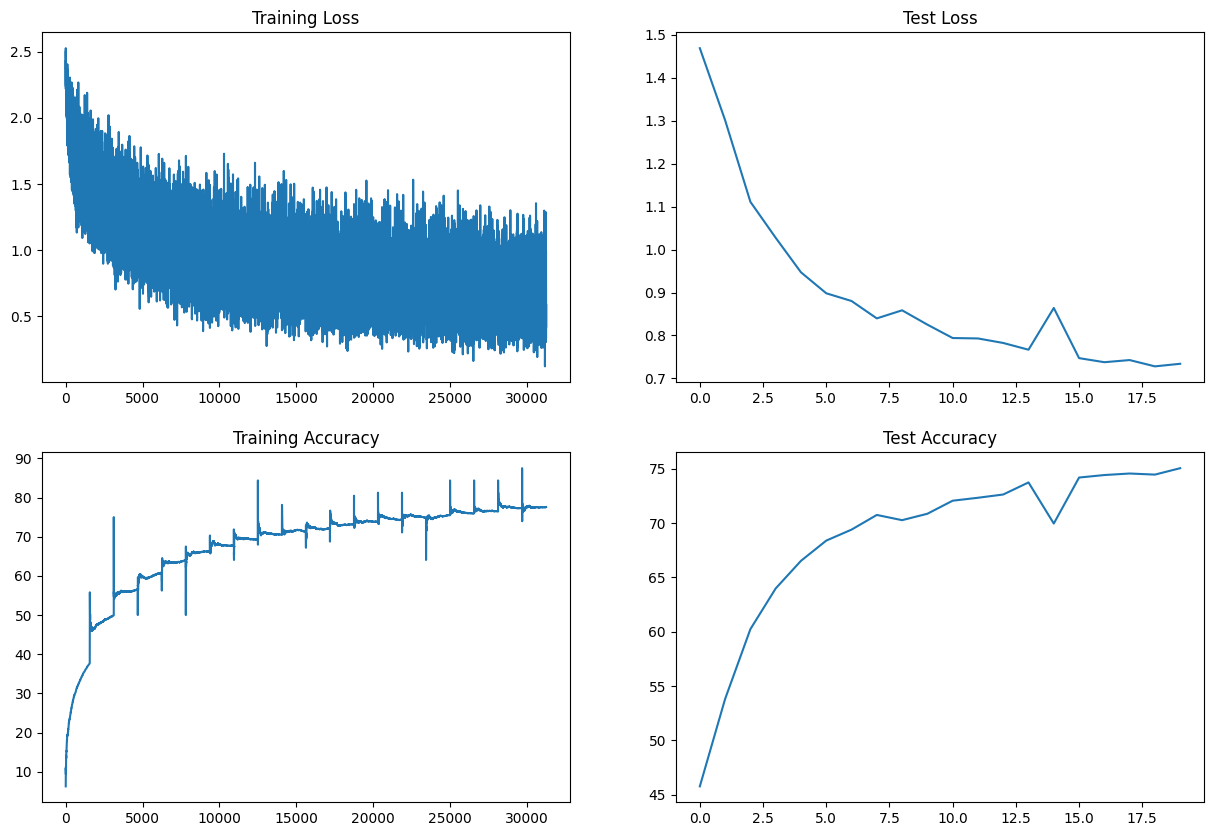

In [9]:
import matplotlib.pyplot as plt

t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


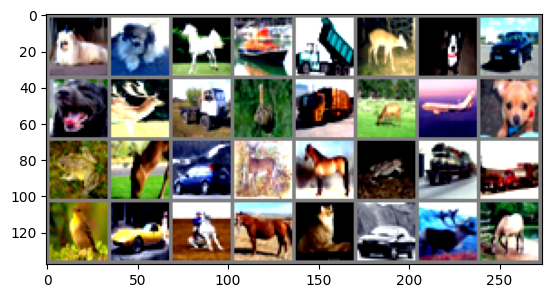

dog   dog   horse ship  truck deer  dog   car   dog   deer  truck bird  truck deer  plane dog   frog  deer  car   deer  horse frog  truck truck bird  car   horse horse cat   car   deer  horse


In [11]:
import numpy as np
from torchvision.utils import make_grid
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)


imshow(make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))
